In [31]:
import matplotlib.pyplot as plt
import pathlib as pl
import flopy
from flopy.mf6.utils import Mf6Splitter

from defaults import *

Set the number of CPU cores that you want the simulation to run on. This should not exceed the number of domains that the model was split in. For efficiency reasons, it should also not exceed the number of processor cores that you have on your machine.

In [32]:
nr_cores = 2

Get the working directories

In [33]:
parallel_dir = get_parallel_dir()
base_dir = get_base_dir()

Load the simulation data for both runs

In [34]:
parallel_sim = flopy.mf6.MFSimulation.load(sim_ws=parallel_dir)
serial_sim = flopy.mf6.MFSimulation.load(sim_ws=base_dir)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading exchange package gwf-gwf_exg_0...
  loading solution package model_0...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading solution package model...


### Run the splitted simulation in parallel

In [35]:
parallel_sim.run_simulation(processors=nr_cores, silent=True)

(True, [])

Collect models, simulation times, head arrays, ...

In [36]:
models = [parallel_sim.get_model(mname) for mname in parallel_sim.model_names]
times = models[0].output.head().get_times()
heads = [m.output.head().get_data(totim=times[-1]) for m in models]
hmin = min([np.amin(h) for h in heads])
hmax = max([np.amax(h[h < 1e+30]) for h in heads])

### Reconstruct the data
The Model Splitter reconstruction functionality takes the following dictonary to merge the result back into one

In [37]:
head_dict = dict(zip(range(0,len(heads)), heads))

Reconstruct

In [38]:
json_path = parallel_dir / "mfsplit_node_mapping.json"
mfsplit = Mf6Splitter(serial_sim)
mfsplit.load_node_mapping(parallel_sim, json_path)
reconstructed_head = mfsplit.reconstruct_array(head_dict)

Get the base reference results

In [39]:
base_gwf = serial_sim.get_model()
base_head = base_gwf.output.head().get_data(totim=times[-1])

### Plot parallel versus serial

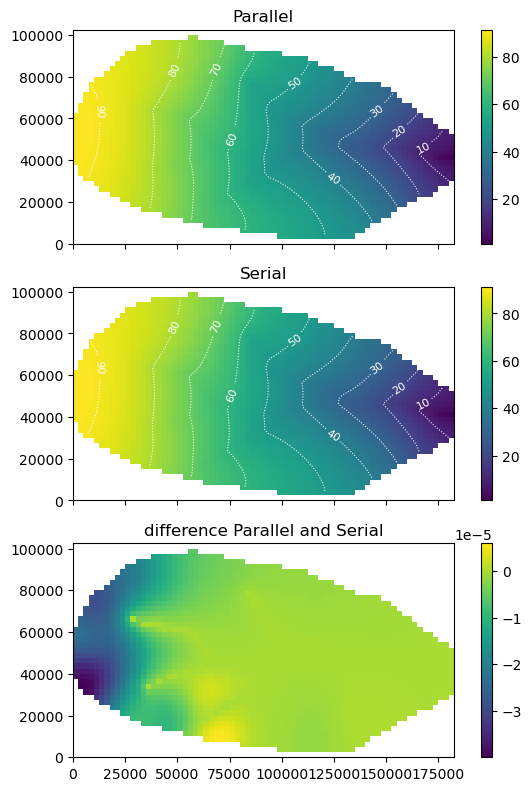

In [40]:
fig = plt.figure(figsize=(figwidth, figheight * 1.3333))
dh = reconstructed_head - base_head
hv = [reconstructed_head, base_head, dh]
titles = ["Parallel", "Serial", "difference Parallel and Serial"]
for idx in range(3):
    ax = fig.add_subplot(3, 1, idx + 1)
    ax.set_aspect("equal")
    ax.set_title(titles[idx])

    if idx < 2:
        levels = np.arange(0, 100, 10)
        vmin = hmin
        vmax = hmax
    else:
        levels = None
        vmin = None
        vmax = None

    pmv = flopy.plot.PlotMapView(model=base_gwf, ax=ax, layer=0)
    h = pmv.plot_array(hv[idx], vmin=vmin, vmax=vmax)
    if levels is not None:
        c = pmv.contour_array(
            hv[idx],
            levels=np.arange(0, 100, 10),
            colors="white",
            linewidths=0.75,
            linestyles=":",
        )
        plt.clabel(c, fontsize=8)
    if base_gwf.modelgrid.idomain is not None:
        pmv.plot_inactive(color_noflow="white")
    plt.colorbar(h, ax=ax)
    if idx < 2: ax.set_xticklabels([])

plt.show()